# Handling categorical varbiables with KernelSHAP 

## Introduction

In this example, we show how the KernelSHAP method can be used for tabular data, which contains both numerical (continuous) and categorical attributes. Using a logistic regression model fitted to the `Adult` dataset, we examine the performance of the KernelSHAP algorithm against the exact shap values. We investigate the effect of the background dataset size on the estimated shap values and present two ways of handling categorical data.

In [2]:
import shap
shap.initjs()

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from alibi.explainers.kernel_shap import KernelShap
from alibi.datasets import fetch_adult
from scipy.special import logit
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder



## Data preparation

### Load and split

The `fetch_adult` function returns a `Bunch` object containing the features, the targets, the feature names and a mapping of categorical variables to numbers.

In [3]:
adult = fetch_adult()
adult.keys()

dict_keys(['data', 'target', 'feature_names', 'target_names', 'category_map'])

In [4]:
data = adult.data
target = adult.target
target_names = adult.target_names
feature_names = adult.feature_names
category_map = adult.category_map

Note that for your own datasets you can use our utility function `gen_category_map` to create the category map.

In [5]:
from alibi.utils.data import gen_category_map

In [6]:
np.random.seed(0)
data_perm = np.random.permutation(np.c_[data, target])
data = data_perm[:,:-1]
target = data_perm[:,-1]

In [7]:
idx = 30000
X_train,y_train = data[:idx,:], target[:idx]
X_test, y_test = data[idx+1:,:], target[idx+1:]

### Create feature transformation pipeline

### Create feature transformation pipeline
Create feature pre-processor. Needs to have 'fit' and 'transform' methods. Different types of pre-processing can be applied to all or part of the features. In the example below we will standardize ordinal features and apply one-hot-encoding to categorical features.

Ordinal features:

In [8]:
ordinal_features = [x for x in range(len(feature_names)) if x not in list(category_map.keys())]
ordinal_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                      ('scaler', StandardScaler())])

Categorical features:

In [9]:
categorical_features = list(category_map.keys())
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                          ('onehot', OneHotEncoder(drop='first', handle_unknown='error'))])

<a id='src_1'></a>
Note that in order to be able to interpret the coefficients corresponding to the categorical features, the option `drop='first'` has been passed to the `OneHotEncoder`. This means that for a categorical variable with `n` levels, the length of the code will be `n-1`. This is necessary in order to avoid introducing feature multicolinearity, which would skew the interpretation of the results. For more information about the issue about multicolinearity in the context of linear modelling see [[1]](#References).

Combine and fit:

In [10]:
preprocessor = ColumnTransformer(transformers=[('num', ordinal_transformer, ordinal_features),
                                               ('cat', categorical_transformer, categorical_features)])
preprocessor.fit(X_train)

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('num',
                                 Pipeline(memory=None,
                                          steps=[('imputer',
                                                  SimpleImputer(add_indicator=False,
                                                                copy=True,
                                                                fill_value=None,
                                                                missing_values=nan,
                                                                strategy='median',
                                                                verbose=0)),
                                                 ('scaler',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                           

### Preprocess the data

In [11]:
X_train_proc = preprocessor.transform(X_train)
X_test_proc = preprocessor.transform(X_test)

## Fit a binary logistic regression classifier to the Adult dataset

### Training 

In [12]:
classifier = LogisticRegression(multi_class='multinomial',
                                random_state=0,
                                max_iter=500,
                                verbose=0,
                               )
classifier.fit(X_train_proc, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Model assessment

In [13]:
y_pred = classifier.predict(X_test_proc)

In [14]:
cm = confusion_matrix(y_test, y_pred)

Text(0.5, 1.0, 'Confusion matrix for the logistic regression classifier')

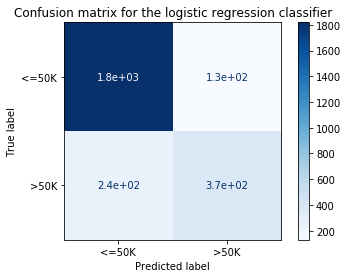

In [15]:
title = 'Confusion matrix for the logistic regression classifier'
disp = plot_confusion_matrix(classifier, 
                             X_test_proc, 
                             y_test,
                             display_labels=target_names,
                             cmap=plt.cm.Blues,
                             normalize=None,
                            )
disp.ax_.set_title(title)

In [16]:
print('Test accuracy: ', accuracy_score(y_test, classifier.predict(X_test_proc)))

Test accuracy:  0.8546875


## Intepreting the logistic regression model

In order to interpret the logistic regression model, we need to first recover the encoded feature names. The feature effect of a categorical variable is computed by summing the coefficients of the encoded variables. Hence, we first understand how the `preprocessing` transformation acts on the data and then obtain the overall effects from the model coefficients.  

First, we are concerned with understanding the dimensionality of a preprocessed record and what it is comprised of.

In [17]:
idx = 0
print("The dimensionality of a preprocessed record is {}.".format(X_train_proc[idx:idx+1, :].shape))
print("Then number of continuos features in the original data is {}.".format(len(ordinal_features)))

The dimensionality of a preprocessed record is (1, 49).
Then number of continuos features in the original data is 4.


Therefore, of 49, 45 of the dimensions of the original data are encoded categorical features. We obtain `feat_enc_dim`, an array with the lengths of the encoded dimensions for each categorical variable that will be use for processing the results later on.

In [18]:
fts = [feature_names[x] for x in categorical_features]
# get feature names for the encoded categorical features
ohe = preprocessor.transformers_[1][1].named_steps['onehot']
cat_enc_feat_names = ohe.get_feature_names(fts)
 # compute encoded dimension; -1 as ohe is setup with drop='first'
feat_enc_dim = [len(cat_enc) - 1 for cat_enc in ohe.categories_]
d = {'feature_names': fts , 'encoded_dim': feat_enc_dim}
df = pd.DataFrame(data=d)
print(df)
total_dim = df['encoded_dim'].sum() 
print("The dimensionality of the encoded categorical features is {}.".format(total_dim))
assert total_dim == len(cat_enc_feat_names)

    feature_names  encoded_dim
0       Workclass            8
1       Education            6
2  Marital Status            3
3      Occupation            8
4    Relationship            5
5            Race            4
6             Sex            1
7         Country           10
The dimensionality of the encoded categorical features is 45.


By analysing an encoded record, we can recover the mapping of column indices to the features they represent.

In [19]:
print(X_train_proc[0, :])  

  (0, 0)	-0.8464456331823879
  (0, 1)	-0.14513571926899238
  (0, 2)	-0.21784551572515998
  (0, 3)	0.28898151525672766
  (0, 7)	1.0
  (0, 15)	1.0
  (0, 19)	1.0
  (0, 21)	1.0
  (0, 32)	1.0
  (0, 37)	1.0
  (0, 47)	1.0


In [20]:
numerical_feats_idx  = preprocessor.transformers_[0][2]
categorical_feats_idx  = preprocessor.transformers_[1][2]
scaler = preprocessor.transformers_[0][1].named_steps['scaler']
print((X_train[idx, numerical_feats_idx] - scaler.mean_)/scaler.scale_)
num_feats_names = [feature_names[i] for i in numerical_feats_idx]
cat_feats_names = [feature_names[i] for i in categorical_feats_idx]
print(num_feats_names)

[-0.84644563 -0.14513572 -0.21784552  0.28898152]
['Age', 'Capital Gain', 'Capital Loss', 'Hours per week']


Therefore, the first four columns of the encoded data represent the `Age`, `Capital Gain` `Capital Loss` and `Hours per week` features. Notice these features have a different index in the dataset prior to processing `X_train`. 

The remainder of the columns encode the encoded categorical features, as shown below.

In [21]:
print(cat_enc_feat_names)

['Workclass_1.0' 'Workclass_2.0' 'Workclass_3.0' 'Workclass_4.0'
 'Workclass_5.0' 'Workclass_6.0' 'Workclass_7.0' 'Workclass_8.0'
 'Education_1.0' 'Education_2.0' 'Education_3.0' 'Education_4.0'
 'Education_5.0' 'Education_6.0' 'Marital Status_1.0' 'Marital Status_2.0'
 'Marital Status_3.0' 'Occupation_1.0' 'Occupation_2.0' 'Occupation_3.0'
 'Occupation_4.0' 'Occupation_5.0' 'Occupation_6.0' 'Occupation_7.0'
 'Occupation_8.0' 'Relationship_1.0' 'Relationship_2.0' 'Relationship_3.0'
 'Relationship_4.0' 'Relationship_5.0' 'Race_1.0' 'Race_2.0' 'Race_3.0'
 'Race_4.0' 'Sex_1.0' 'Country_1.0' 'Country_2.0' 'Country_3.0'
 'Country_4.0' 'Country_5.0' 'Country_6.0' 'Country_7.0' 'Country_8.0'
 'Country_9.0' 'Country_10.0']


To obtain a single coefficient for each categorical variable, we pass a list with the indices where each encoded categorical variable starts and the encodings dimensions to the `sum_categories` function.

In [22]:
from alibi.explainers.kernel_shap import sum_categories

Compute the start index of each categorical variable knowing that the categorical variables are adjacent and follow the continuous features.

In [23]:
start=len(ordinal_features)
cat_feat_start = [start]
for dim in feat_enc_dim[:-1]:
    cat_feat_start.append(dim + cat_feat_start[-1])

In [24]:
beta = classifier.coef_
beta = np.concatenate((-beta, beta), axis=0)
intercepts = classifier.intercept_
intercepts =  np.concatenate((-intercepts, intercepts), axis=0)
all_coef = sum_categories(beta, cat_feat_start, feat_enc_dim)

Extract and plot feature importances. Please see [this](kernel_shap_wine_lr.ipynb) example for background on interpreting logistic regression coefficients.

In [25]:
def extract_importances(class_idx, beta, feature_names, intercepts=None):
    """
    Retrive and sort abs magnitude of coefficients from model.
    """
    
    # sort the absolute value of model coef from largest to smallest
    srt_beta_k = np.argsort(np.abs(beta[class_idx, :]))[::-1]
    feat_names = [feature_names[idx] for idx in srt_beta_k]
    feat_imp = beta[class_idx, srt_beta_k]
    # include bias among feat importances 
    if intercepts is not None: 
        intercept = intercepts[class_idx]
        bias_idx = len(feat_imp) - np.searchsorted(np.abs(feat_imp)[::-1], np.abs(intercept) )
        feat_imp = np.insert(feat_imp, bias_idx, intercept.item(), )
        intercept_idx = np.where(feat_imp == intercept)[0][0]
        feat_names.insert(intercept_idx, 'bias')

    return feat_imp, feat_names

def plot_importances(feat_imp, feat_names, class_idx, **kwargs):
    """
    Create a horizontal barchart of feature effects, sorted by their magnitude.
    """
    
    left_x, right_x = kwargs.get("left_x"), kwargs.get("right_x")
    eps_factor = kwargs.get("eps_factor", 4.5)
    
    fig, ax = plt.subplots(figsize=(10, 5))
    y_pos = np.arange(len(feat_imp))
    ax.barh(y_pos, feat_imp)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(feat_names, fontsize=15)
    ax.invert_yaxis()                  # labels read top-to-bottom
    ax.set_xlabel('Feature effects for class {}'.format(class_idx), fontsize=15)
    ax.set_xlim(left=left_x, right=right_x)
    
    for i, v in enumerate(feat_imp):
        eps = 0.03
        if v < 0:
            eps = -eps_factor*eps
        ax.text(v + eps, i + .25, str(round(v, 3)))
    
    return ax, fig

In [26]:
class_idx = 0
perm_feat_names = num_feats_names + cat_feats_names 

In [27]:
perm_feat_names # feats are reordered by preprocessor

['Age',
 'Capital Gain',
 'Capital Loss',
 'Hours per week',
 'Workclass',
 'Education',
 'Marital Status',
 'Occupation',
 'Relationship',
 'Race',
 'Sex',
 'Country']

In [28]:
feat_imp, srt_feat_names = extract_importances(class_idx, 
                                               all_coef, 
                                               perm_feat_names,
                                              )

In [29]:
srt_feat_names

['Marital Status',
 'Education',
 'Capital Gain',
 'Occupation',
 'Workclass',
 'Race',
 'Country',
 'Sex',
 'Relationship',
 'Hours per week',
 'Age',
 'Capital Loss']

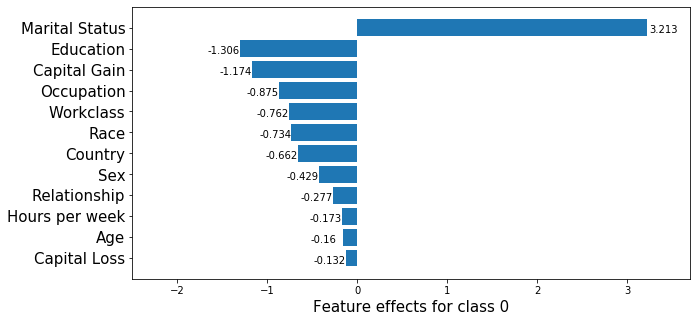

In [30]:
_, class_0_fig = plot_importances(feat_imp, 
                                  srt_feat_names, 
                                  class_idx,
                                  left_x=-2.5,
                                  right_x=3.7,
                                  eps_factor=12  # controls text distance from end of bar
                                  )

Note that in the above, the feature effects are with respect to the model bias, which has a value of $1.31$.

In [31]:
# Sanity check to ensure graph is correct.
print(beta[class_idx, 0:4]) # Age, Capital Gains, Capital Loss, Hours per week 
print(np.sum(beta[class_idx, 18:21])) # Marital status

[-0.1599102  -1.17411246 -0.13217129 -0.17287053]
3.213016468237247


## Apply KernelSHAP to explain the model

<a id='src_1'></a>
Note that the *local accuracy* property of SHAP (eq. (5) in [[1]](#ref_1))  requires
\begin{equation*}
f(x) = g(x') = \phi_0 + \sum_{i=1}^M \phi_i x_i'.
\label{eq:local_acc} \tag{1}
\end{equation*}
Hence, sum of the feature importances should be equal to the model output, $f(x)$. By passing `link='logit'` to the explainer, we ensure that $\phi_0$, the *base value* (see _**Local explanation**_ section [here](kernel_shap_wine_intro.ipynb)) will be calculated in the margin space (i.e., a logit transformation is applied to the probabilities) where the logistic regression model is additive.

Further considerations when applying the KernelSHAP method to this dataset are:
- ***the background dataset size***: by setting a larger value for the `stop_example_idx` in the set below, you can observe how the runtime of the algorithm increases. At the same time, it is important to have a diverse but sufficiently large set of samples as background so that the missing feature values are correctly integrated. A way to reduce the number of samples is to pass the `summarise_background=True` flag to the explainer `fit` option along with the desired number of samples (`n_background_samples`). If there are no categorical variables in the data and there is no data  grouping, then a k-means clustering algorithm is used to summarise the data. Otherwise, the data is sampled uniformly at random. Below, we used the `train_test_split` function of `sklearn` instead so that the label proportions are approximately the same as in the original split. 
- ***the number of instances to be explained***: the test set contains a number of `2560` records, which are $49$-dimensional after pre-processing, as opposed to $13$-dimensional as in the Wine dataset example. For this reason, only a fraction of `fraction_explained` (default $5\%$) are explained by way of getting a more general view of the model behaviour compared to simply analysing local explanations 
- ***treating the encoded categorical features as a group*** of features that are ***jointly*** perturbed as opposed to being perturbed individually

In [32]:
def split_set(X, y, fraction, random_state=0):
    """
    Given a set X, associated labels y, splits a fraction y from X.
    """
    _, X_split, _, y_split = train_test_split(X, 
                                              y, 
                                              test_size=fraction, 
                                              random_state=random_state,
                                             )
    print("Number of records: {}".format(X_split.shape[0]))
    print("Number of class {}: {}".format(0, len(y_split) - y_split.sum()))
    print("Number of class {}: {}".format(1, y_split.sum()))
    
    return X_split, y_split

In [33]:
fraction_explained = 0.05 
X_explain, y_explain = split_set(X_test, 
                                 y_test, 
                                 fraction_explained, 
                                 )
X_explain_proc = preprocessor.transform(X_explain)

Number of records: 128
Number of class 0: 96
Number of class 1: 32


In [34]:
# Select only 100 examples for the background dataset to speedup computation
start_example_idx = 0
stop_example_idx = 100
background_data = slice(start_example_idx, stop_example_idx)

### Exploiting explanation model additivity to estimate the effects of categorical features

Inspired by equation (1), a way to estimate the overall effect of a categorical variable is to treat its encoded levels as individual binary variables and sum the estimated effects for the encoded dimensions. 

In [35]:
pred_fcn = classifier.predict_proba
lr_explainer = KernelShap(pred_fcn, link='logit', feature_names=perm_feat_names)
lr_explainer.fit(X_train_proc[background_data, :])

In [36]:
# passing the logit link function to the explainer ensures the units are consistent ...
mean_scores_train = logit(pred_fcn(X_train_proc[background_data, :]).mean(axis=0))
# print(mean_scores_train - lr_explainer.expected_value)  

In [37]:
lr_explainer.expected_value

array([ 1.0878651, -1.0878651])

In [ ]:
explanation = lr_explainer.explain(X_explain_proc, 
                                   summarise_result=True,
                                   cat_vars_start_idx=cat_feat_start,
                                   cat_vars_enc_dim=feat_enc_dim,
                                  ) 

We now sum the estimate shap values for each dimension to obtain one shap value for each categorical variable!

In [39]:
def rank_features(shap_values, feat_names):
    """
    Given an NxF array of shap values where N is the number of 
    instances and F number of features, the function ranks the
    shap values according to their average magnitude. 
    """
    
    avg_mag = np.mean(np.abs(shap_values), axis=0)
    srt = np.argsort(avg_mag)[::-1]
    rank_values = avg_mag[srt]
    rank_names = [feat_names[idx] for idx in srt]
    
    return rank_values, rank_names



def get_ranked_values(explanation):
    """
    Retrives a tuple of (feature_effects, feature_names) for
    each class explained. A feature's effect is its average
    shap value magnitude across an array of instances.
    """
    
    ranked_shap_vals = []
    for cls_idx in range(len(explanation.shap_values)):
        this_ranking = (
            explanation.raw['importances'][str(cls_idx)]['ranked_effect'],
            explanation.raw['importances'][str(cls_idx)]['names']
                       )
        ranked_shap_vals.append(this_ranking)
    
    return ranked_shap_vals

In [40]:
ranked_combined_shap_vals = get_ranked_values(explanation)

Because the columns have been permuted by the `preprocessor`, the columns of the instances to be explained have to be permuted before creating the summary plot.

In [41]:
perm_feat_names

['Age',
 'Capital Gain',
 'Capital Loss',
 'Hours per week',
 'Workclass',
 'Education',
 'Marital Status',
 'Occupation',
 'Relationship',
 'Race',
 'Sex',
 'Country']

In [42]:
def permute_columns(X, feat_names, perm_feat_names):
    """
    Permutes the original dataset so that its columns
    (ordered according to feat_names) have the order 
    of the variables after transformation with the 
    sklearn preprocessing pipeline (perm_feat_names).
    """
    
    perm_X = np.zeros_like(X)
    perm = []
    for i, feat_name in enumerate(perm_feat_names):
        feat_idx = feat_names.index(feat_name)
        perm_X[:, i] = X[:, feat_idx]
        perm.append(feat_idx)
    return perm_X, perm

In [43]:
perm_X_explain, _ = permute_columns(X_explain, feature_names, perm_feat_names)

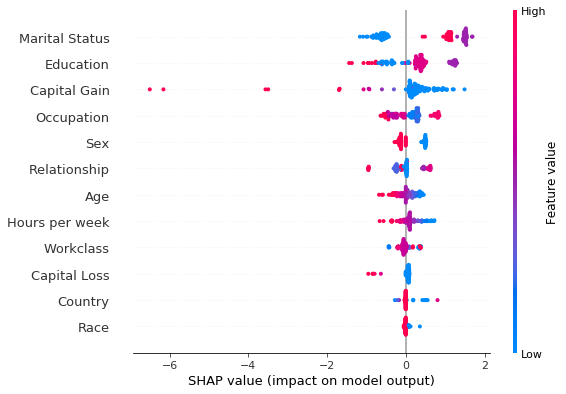

In [44]:
shap.summary_plot(explanation.shap_values[0], perm_X_explain, perm_feat_names)

Note that the aggregated local explanations of this limited set are in partial agreement with the global explanation provided by the model coefficients. The top `3` most important features are determined to be the same. We can see that, high values of the `Capital Gains` decrease the odds of a sample being classified as `class_0` (income <$50k).

### Grouping features with KernelShap

<a id='src_3'></a>
<a id='f_1'></a>
<a id='f_2'></a>
<a id='f_3'></a>
<a id='f_4'></a>
An alternative way to deal with one-hot encoded categorical variables is to group the levels of a categorical variables and treat them as a single variable during the sampling process that generates the training data for the explanation model. Dealing with the categorical variables in this way can help reduce the variance of the shap values estimate <sup>[**1**](#footnotes) </sup>. Note that this does not *necessarily* result in a runtime saving: by default the algorithm estimates the shap values by creating a training dataset for the weighed regression, which consists of tiling `nsamples` <sup>[**2**](#footnotes) </sup> copies of the background dataset. By default, this parameter is set to `auto`, which is given by `2*M + 2**11` where `M` is the number of features which can be perturbed. Therefore, because `2*M < 2 ** 11`, one should not expect to see significant time savings when reducing the number of columns. The runtime can be improved by reducing `nsamples` at the cost of a loss in estimation accuracy.<sup> [**3**](#footnotes)</sup>


The following arguments should be passed to the `fit` step in order to perform grouping:

- `background_data`: in this case, `X_train_proc`<sup>[**4**](#footnotes) </sup>
- `group_names`: a list containing the feature names
- `groups`: for each feature name in `group_name`, `groups` contains a list of column indices in `X_train_proc` which represent that feature.

In [45]:
def make_groups(num_feats_names, cat_feats_names, feat_enc_dim):
    """
    Given a list with numerical feat. names, categorical feat. names
    and a list specifying the lengths of the encoding for each cat.
    varible, the function outputs a list of group names, and a list
    of the same len where each entry represents the column indices that
    the corresponding categorical feature 
    """
    
    group_names = num_feats_names + cat_feats_names
    groups = []
    cat_var_idx = 0
    
    for name in group_names: 
        if name in num_feats_names:
            groups.append(list(range(len(groups), len(groups) + 1)))
        else:
            start_idx = groups[-1][-1] + 1 if groups else 0
            groups.append(list(range(start_idx, start_idx + feat_enc_dim[cat_var_idx] )))
            cat_var_idx += 1
    
    return group_names, groups
            
def sparse2ndarray(mat, examples=None):
    """
    Converts a scipy.sparse.csr.csr_matrix to a numpy.ndarray.
    If specified, examples is slice object specifying which selects a
    number of rows from mat and converts only the respective slice.
    """
    
    if examples:
        return mat[examples, :].toarray()
    
    return mat.toarray()

In [46]:
X_train_proc_d = sparse2ndarray(X_train_proc, examples=background_data)
group_names, groups = make_groups(num_feats_names, cat_feats_names, feat_enc_dim)

Having created the groups, we are now ready to instantiate the explainer and explain our set. 

In [48]:
X_explain_proc_d = sparse2ndarray(X_explain_proc)
grp_lr_explainer = KernelShap(pred_fcn, link='logit', feature_names=perm_feat_names)
grp_lr_explainer.fit(X_train_proc_d, group_names=group_names, groups=groups)

In [ ]:
grouped_explanation = grp_lr_explainer.explain(X_explain_proc_d)

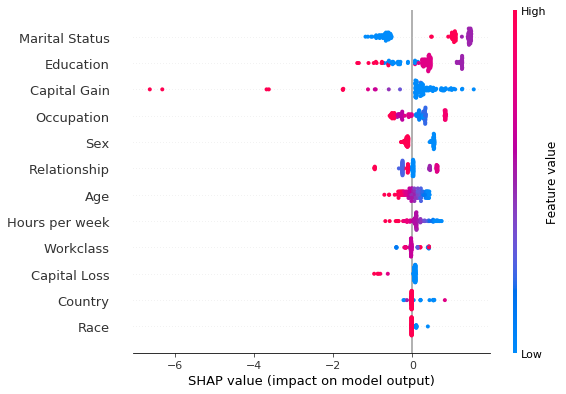

In [50]:
shap.summary_plot(grouped_explanation.shap_values[0], perm_X_explain, perm_feat_names)

In [51]:
ranked_grouped_shap_vals = get_ranked_values(grouped_explanation)

Having ranked the features by the average magnitude of their shap value, we can now see if they provide the same ranking.

In [52]:
def compare_ranking(ranking_1, ranking_2, methods=None):
    for i, (combined, grouped) in enumerate(zip(ranking_1, ranking_2)):
        print("Class: {}".format(i))
        c_names, g_names = combined[1], grouped[1]
        c_mag, g_mag = combined[0], grouped[0]
        different = []
        for i, (c_n, g_n) in enumerate(zip(c_names, g_names)):
            if c_n != g_n:
                different.append((i, c_n, g_n))
        if different:
            method_1 = methods[0] if methods else "Method_1"
            method_2 = methods[1] if methods else "Method_2"
            i, c_ns, g_ns = list(zip(*different))
            data = {"Rank": i, method_1: c_ns, method_2: g_ns}
            df = pd.DataFrame(data=data)
            print("Found the following rank differences:")
            print(df)
        else:
            print("The methods provided the same ranking for the feature effects.")
            print("The ranking is: {}".format(c_names))
        print("")
        
compare_ranking(ranked_combined_shap_vals, ranked_grouped_shap_vals)

Class: 0
The methods provided the same ranking for the feature effects.
The ranking is: ['Marital Status', 'Education', 'Capital Gain', 'Occupation', 'Sex', 'Relationship', 'Age', 'Hours per week', 'Workclass', 'Capital Loss', 'Country', 'Race']

Class: 1
The methods provided the same ranking for the feature effects.
The ranking is: ['Marital Status', 'Education', 'Capital Gain', 'Occupation', 'Sex', 'Relationship', 'Age', 'Hours per week', 'Workclass', 'Capital Loss', 'Country', 'Race']



As shown in [this](kernel_shap_wine_lr.ipynb) example, for a logistic regression model, the exact shap values can be computed as shown below. Note that,  like `KernelShap`, this computation makes the assumption that the features are independent.

In [67]:
exact_shap = [(beta[:, None, :]*X_explain_proc_d)[i, ...] for i in range(beta.shape[0])] 
combined_exact_shap = [sum_categories(shap_values, cat_feat_start, feat_enc_dim) for shap_values in exact_shap]
ranked_combined_exact_shap = [rank_features(vals, perm_feat_names) for vals in combined_exact_shap]

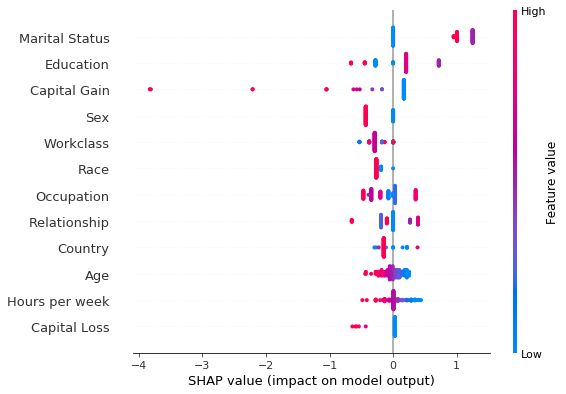

In [58]:
shap.summary_plot(combined_exact_shap[0], perm_X_explain, perm_feat_names )

Comparing the two summary plots above, we notice that albeit the estimation and the exact method rank the features `Marital Status`, `Education` and `Capital Gain` as the features that are most important for the classification decision, the ranking of the remainder of the features differs. In particular, while `Race` is estimated to be the sixth more important feature   using the exact shap value computation, it is deemed as the least important in the approximate computation. However, note that the exact shap value calculation takes into account the weight estimated by the logistic regression model. All the weights in the model are estimated jointly so that the model predictive distribution matches the predictive distribution of the training data. Thus, the values of the coefficients are a function of the entire dataset. On the other hand, to limit the computation time, the shap values are estimated using a small background dataset. This error is compounded by the fact that the estimation is approximate, since computing the exact values using the weighted regression has exponential computational complexity. Below, we show that the `Race` feature distribution is heavily skewed towards white individuals. Investigating correcting this imbalance would lead to more accurate estimation is left to future work.

In [69]:
from functools import partial
from collections import Counter

In [70]:
def get_feature_distribution(dataset, feature, category_map, feature_names):
    """Given a map of categorical variable indices to human-readable 
    values and an array of feature integer values, the function outputs 
    the distribution the feature in human readable format."""
    feat_mapping = category_map[feature_names.index(feature)]
    distrib_raw = Counter(dataset)
    distrib = {feat_mapping[key]: val for key, val in distrib_raw.items()}
    
    return distrib

In [71]:
get_distribution = partial(get_feature_distribution, feature_names=feature_names, category_map=category_map)
race_idx = feature_names.index("Race")
bkg_race_distrib = get_distribution(X_train[background_data, race_idx], 'Race')
train_race_distrib = get_distribution(X_train[:, race_idx], 'Race')
expl_race_distrib = get_distribution(X_explain[:, race_idx], 'Race')

In [72]:
print("Background data race distribution:")
print(bkg_race_distrib)
print("Train data race distribution:")
print(train_race_distrib)
print("Explain race distribution:")
print(expl_race_distrib)

Background data race distribution:
{'White': 89, 'Amer-Indian-Eskimo': 2, 'Black': 8, 'Asian-Pac-Islander': 1}
Train data race distribution:
{'White': 25634, 'Amer-Indian-Eskimo': 285, 'Black': 2868, 'Asian-Pac-Islander': 963, 'Other': 250}
Explain race distribution:
{'White': 105, 'Black': 20, 'Asian-Pac-Islander': 2, 'Amer-Indian-Eskimo': 1}


We now look to compare the approximate and the exact shap values as well as the relation between the shap computation and the logistic regression coefficients.

In [372]:
def reorder_feats(vals_and_names, src_vals_and_names):
    """Given a two tuples, each containing a list of ranked feature
    shap values and the corresponding feature names, the function 
    reorders the values in vals according to the order specified in
    the list of names contained in src_vals_and_names.
    """
    
    _, src_names = src_vals_and_names
    vals, names = vals_and_names
    reordered = np.zeros_like(vals)
    
    for i, name in enumerate(src_names):
        alt_idx = names.index(name)
        reordered[i] = vals[alt_idx]
    
    return reordered, src_names

def compare_avg_mag_shap(class_idx, comparisons, baseline, **kwargs):
    """
    Given a list of tuples, baseline, containing the feature values and a list with feature names 
    for each class and, comparisons, a list of lists with tuples with the same structure , the 
    function reorders the values of the features in comparisons entries according to the order 
    of the feature names provided in the baseline entries and displays the feature values for comparison.
    """
    
    methods = kwargs.get("methods", ["method_{}".format(i) for i in range(len(comparisons) + 1)])
    
    n_features = len(baseline[class_idx][0])
    
    # bar settings
    bar_width = kwargs.get("bar_width", 0.05)
    bar_space = kwargs.get("bar_space", 2)
    
    # x axis 
    x_low = kwargs.get("x_low", 0.0)
    x_high = kwargs.get("x_high", 1.0)
    x_step = kwargs.get("x_step", 0.05)
    x_ticks = np.round(np.arange(x_low, x_high + x_step, x_step), 3)

    # y axis (these are the y coordinate of start and end of each group 
    # of bars)
    start_y_pos = np.array(np.arange(0, n_features))*bar_space
    end_y_pos = start_y_pos + bar_width*len(methods)
    y_ticks = 0.5*(start_y_pos + end_y_pos)
    
    # figure 
    fig_x = kwargs.get("fig_x", 10)
    fig_y = kwargs.get("fig_y", 7)
    
    # fontsizes 
    title_font = kwargs.get("title_fontsize", 20)
    legend_font = kwargs.get("legend_fontsize", 20)
    tick_labels_font = kwargs.get("tick_labels_fontsize", 20)
    axes_label_fontsize = kwargs.get("axes_label_fontsize", 10)
    
    # labels 
    title = kwargs.get("title", None)
    ylabel = kwargs.get("ylabel", None)
    xlabel = kwargs.get("xlabel", None)
    
    # process input data 
    methods = list(reversed(methods))
    base_vals = baseline[class_idx][0] 
    ordering = baseline[class_idx][1]
    comp_vals = []
    
    # reorder the features so that they match the order of the baseline (ordering)
    for comparison in comparisons:
        vals, ord_ = reorder_feats(comparison[class_idx], baseline[class_idx])
        comp_vals.append(vals)
        assert ord_ is ordering 
        
    all_vals = [base_vals] + comp_vals
    data = dict(zip(methods, all_vals))
    df = pd.DataFrame(data=data, index=ordering)
    
    # plotting logic
    fig, ax = plt.subplots(figsize=(fig_x, fig_y))

    for i, col in enumerate(df.columns):
        values = list(df[col])
        y_pos = [y + bar_width*i for y  in start_y_pos] 
        ax.barh(y_pos, list(values), bar_width, label=col)
    
    # add ticks, legend and labels
    ax.set_xticks(x_ticks)
    ax.set_xticklabels([str(x) for x in x_ticks], rotation=45, fontsize=tick_labels_font)
    ax.set_xlabel(xlabel, fontsize=axes_label_fontsize)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(ordering, fontsize=tick_labels_font)
    ax.set_ylabel(ylabel, fontsize=axes_label_fontsize)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.legend(fontsize=legend_font)   

    plt.grid(True)
    plt.title(title, fontsize=title_font)

    return ax, fig, df

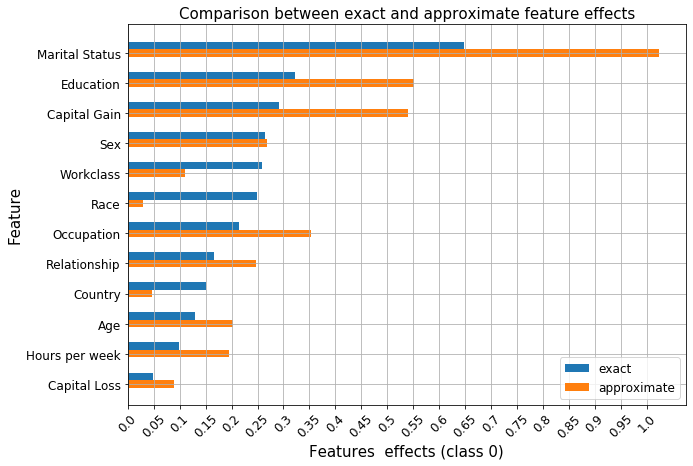

In [356]:
class_idx = 0 
ax, fig, _ = compare_avg_mag_shap(class_idx, 
                               [ranked_combined_shap_vals], 
                               ranked_combined_exact_shap, 
                               methods=('approximate', 'exact'),
                               bar_width=0.5,
                               tick_labels_fontsize=12,
                               legend_fontsize=12,
                               title="Comparison between exact and approximate feature effects",
                               title_fontsize=15,
                               xlabel="Features  effects (class {})".format(0),
                               ylabel="Feature",
                               axes_label_fontsize=15,
                               )

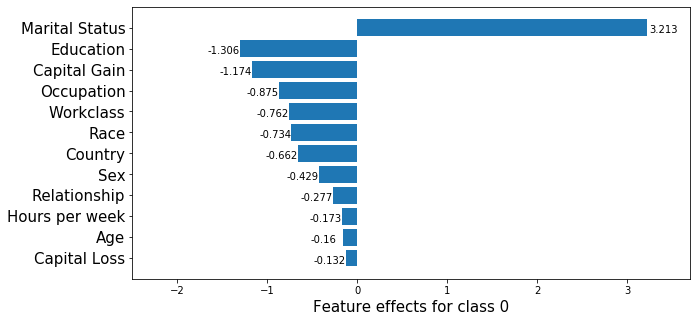

In [75]:
class_0_fig

<a id='ref_4'></a>
<a id='f_7'></a>

As before, we see that features such as `Occupation`, `Workclass` or `Race` have similar effects according to the  ranking of the logistic regression coefficients and that the exact shap value estimation recovers this effect since it is computed using the underlying coefficients. Unlike in our previous example, these relationships are not recovered by the approximate estimation procedure. Therefore, whenever possible, exact shap value computation should be preferred to approximations. As shown in this example it is possible to calculate exact shap values for linear models and exact algorithms exist for tree models. The approximate procedure still gives insights into the model, but, as shown above, it can be quite sensitive when the effects of the variables are similar. The notable differences between the two explanations are the importance of the `Race` and `Country` are underestimated by a significant margin and their rank significantly differs from the exact computation. 

Finally, as noted in [[4]](#ref_1) as the model bias<sup> [**7**](#footnotes)</sup>  increases, more weight can be assigned to irrelevant features. This is perhaps expected since a linear model will suffer from bias when applied to data generated from a nonlinear process, so we don't expect the feature effects to be accurately estimated. This also affects the exact shap values, which depend on these coefficients.

### Investigating the feature effects given a range of feature values

Given an individual record, one could ask questions of the type _What would have been the effect of feature x had its value been y?_. To answer this question one can create hypothetical instances starting from a base record, where the hypothetical instances have a different value for a chosen feature than the original record. Below, we study the effect of the `Capital Gain` feature as a function of its value. We choose the `0th` record in the `X_explain` set, which represents an individual with no capital gain.

In [76]:
idx = 0
base_record = X_explain[idx, ]
cap_gain = X_explain[idx,feature_names.index('Capital Gain')]
print("The capital gain of individual {} is {}!".format(idx, cap_gain))

The capital gain of individual 0 is 0!


We now create a dataset of records that differ from a base record only by the `Capital Gain` feature.

In [77]:
cap_increment = 100
cap_range = range(0, 10100, cap_increment)
hyp_record = np.repeat(base_record[None, :], len(cap_range), axis=0)
hyp_record[:, feature_names.index('Capital Gain')] = cap_range
assert (hyp_record[1, :] - hyp_record[0, ]).sum() == cap_increment
X_hyp_proc = preprocessor.transform(hyp_record)
X_hyp_proc_d = X_hyp_proc.toarray()

We can explain the hypothetical instances in order to understand the change in the `Capital Gain` effect as a function of its value.

In [ ]:
hyp_explainer = KernelShap(pred_fcn, link='logit', feature_names=perm_feat_names)
hyp_explainer.fit(X_train_proc_d, group_names=group_names, groups=groups)
hyp_explanation = hyp_explainer.explain(X_hyp_proc_d)

In [79]:
hyp_record_perm, _ = permute_columns(hyp_record, feature_names, perm_feat_names)

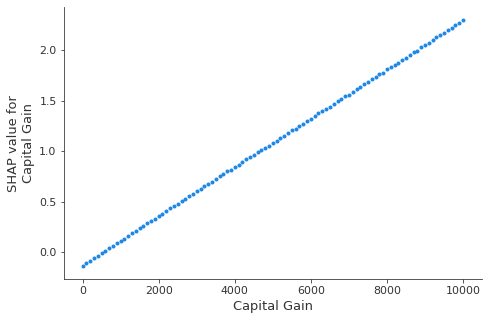

In [80]:
shap.dependence_plot('Capital Gain', 
                     hyp_explanation.shap_values[1], 
                     hyp_record_perm, 
                     feature_names=perm_feat_names, 
                     interaction_index=None,
                    )

In a logistic regression model, the predictors are linearly related to the logits. Estimating the shap values using the KernelShap clearly recovers this aspect, as shown by the plot above. The dependence of the feature effect on the feature value has important implications on the shap value estimation; since the model relies on using the background dataset to simulate the effect of _missing_ inputs in order to estimate any feature effect, it is important to select an appropriate background dataset in order to avoid biasing the estimate of the feature effect of interest. Below, we will experiment with the size of the background dataset, split from the training set of the classifier while keeping the class represensation proportions of the training set roughly the same.

An alternative way to display the effect of a value as a function of the feature value is to group the similar prediction paths, which can be done by specifying the `hclust` feature ordering option.

In [81]:
# obtain the human readable vesion of the base record (for display purposes)
base_perm, perm = permute_columns(base_record[None, :], feature_names, perm_feat_names)
br = []
for i, x in enumerate(np.nditer(base_record.squeeze())):
    if i in categorical_features:
        br.append(category_map[i][x])
    else:
        br.append(x.item())
br = [br[i] for i in perm]
df = pd.DataFrame(data=np.array(br).reshape(1, -1), columns=perm_feat_names)

In [82]:
df

,Age,Capital Gain,Capital Loss,Hours per week,Workclass,Education,Marital Status,Occupation,Relationship,Race,Sex,Country
0,49,0,0,55,Private,Prof-School,Never-Married,Professional,Not-in-family,White,Female,United-States


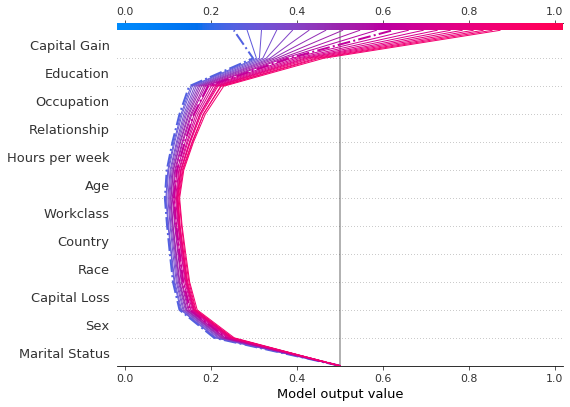

In [84]:
r = shap.decision_plot(hyp_explainer.expected_value[1], 
                       hyp_explanation.shap_values[1][0:-1:5], 
                       hyp_record_perm, 
                       link='logit', 
                       feature_names=perm_feat_names,
                       feature_order='hclust', 
                       highlight=[0, 10],
                       new_base_value = 0.0,
                       return_objects=True)

In [85]:
hyp_record[0:-1:5][10,:]

array([  49,    4,    6,    1,    5,    1,    4,    0, 5000,    0,   55,
          9])

<a id='f_6'></a>
The decision plot above informs us of the path to the decision `Income < $50,0000` for the original record (depicted in blue, and, for clarity, on its own below). Aditionally, decision paths for fictitious records where only the `Capital Gain` feature was altered are displayed. For clarity, only a handful of these instances have been plotted. Note that the base value of the plot has been altered to be the classification threshold <sup>[**6**](#footnotes) </sup> as opposed to the expected prediction probability for individuals earning more than \$50,000.

We see that the second highlighted instance (in purple) would have been predicted as making an income over \$50, 0000 with approximately `0.6` probability, and that this change in prediction is largely dirven by the `Capital Gain` feature. We can see below that the income predictor would have predicted the income of this individual to be  more than \$50, 000 had the `Capital Gain` been over \$3,500. 

In [86]:
# the 7th record from the filtered ones would be predicted to make an income > $50k
income_pred_probas = pred_fcn(preprocessor.transform(hyp_record[0:-1:5][7,:][None,:]))
print("Prediction probabilities: {}".format(income_pred_probas))
# we can see that the minimum capital gain for the prediction to change is: $3,500
cap_gain_min = hyp_record[0:-1:5][7,feature_names.index('Capital Gain')]
print("Minimum capital gain is: ${}".format(cap_gain_min))

Prediction probabilities: [[0.49346669 0.50653331]]
Minimum capital gain is: $3500


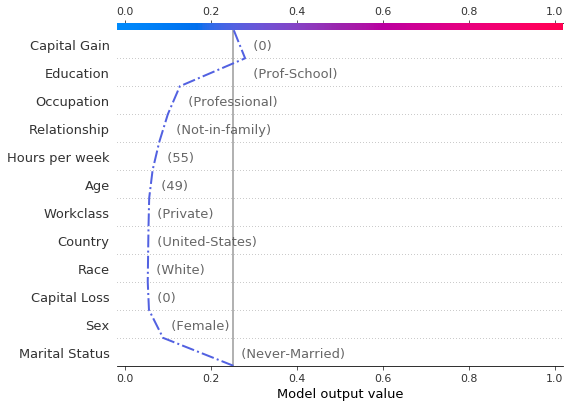

In [88]:
shap.decision_plot(hyp_explainer.expected_value[1], 
                   hyp_explanation.shap_values[1][0], 
                   df, 
                   link='logit', 
                   feature_order=r.feature_idx, 
                   highlight=0
                  )

<a id='f_5'></a>

Note that passing `return_objects=True` and using the `r.feature_idx` as an input to the decision plot above we were able to plot the original record along with the feature values in the same feature order. Additionally, by passing `logit` to the plotting function, the scale of the axis is mapped from the margin to probability space<sup>[**5**](#footnotes) </sup>.

Combined, the two decision plots show that:

- the largest decrease in the probability of earning more than \$50,000 is significantly affected if the individual is has marital status `Never-Married`
- the largest increase in the probability of earning more than \$50,000 is determinbed by the education level
- the probability of making an income greater than \$50,000 increases with the capital gain; notice how this implies that features such as `Education` or `Occupation` also cotribute more to the increase in probability of earning more than \$50,000

### Checking if prediction paths significantly differ for extreme probability predictions

One can employ the decision plot to check if the prediction paths for low (or high) probability examples differ significantly; conceptually, examples which exhibit prediction paths which are significantly different are potential outliers.

Below, we seek to explain only those examples which are predicted to have an income above \$ 50,000 with small probability.

In [89]:
predictions = classifier.predict_proba(X_explain_proc)
low_prob_idx = np.logical_and(predictions[:, 1] <= 0.1, predictions[:, 1] >= 0.03)
X_low_prob = X_explain_proc[low_prob_idx, :]

In [ ]:
low_prob_explanation = hyp_explainer.explain(X_low_prob.toarray())

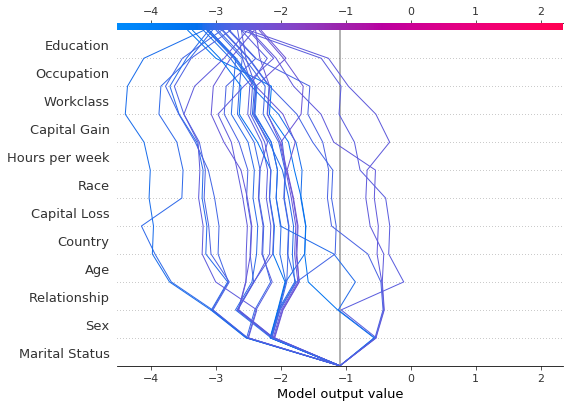

In [92]:
X_low_prob_perm, _ = permute_columns(X_explain[low_prob_idx, :], feature_names, perm_feat_names)

shap.decision_plot(hyp_explainer.expected_value[1],
                   low_prob_explanation.shap_values[1], 
                   X_low_prob_perm, 
                   feature_names=perm_feat_names,
                   feature_order='hclust')

From the above plot, we see that the prediction paths for the samples with low probability of being class 1 are similar - no potential outliers are identified.

### Investigating the effect of the background dataset size on shap value estimates

The shap values estimation relies on quering the model with samples where certain inputs are toggled off in order to infer the contribution of a particular  feature. Since most models cannot accept arbitrary patterns of missing values, the background dataset is used to replace the values of the missing features, that is, as a *background model*. In more detail, the algorithm creates first creates a number of copies of this dataset, and then subsamples sets of   

Since the model predicts on these perturbed samples and regresses on the predictions to infer the shap values, the quality of the background model is key for the explanation model. Here we will not be concerned with modelling the background, but instead investigate whether simply increasing the background set size can give rise to wildly different shap values. This part of the example is **long running** so the graph showing our original results can be loaded instead. 

In [93]:
import pickle

In [94]:
def get_dataset(X_train, y_train, split_fraction):
    """
    Splits and transforms a dataset
    """
    
    split_X, _ = split_set(X_train, y_train, split_fraction)
    split_X_proc = preprocessor.transform(split_X)
    split_X_proc_d = sparse2ndarray(split_X_proc)

    return split_X_proc_d

Below cell is long running, skip and display the graph instead.

In [ ]:
split_fractions = [0.005, 0.01, 0.02, 0.04 ,0.08, 0.16]
exp_data = {'data': [],
            'explainers': [],
            'raw_shap': [],
            'split_fraction': [],
            'ranked_shap_vals': [],
           }
fname = 'experiment.pkl'

for fraction in split_fractions:
    data = get_dataset(X_train, y_train, fraction)
    explainer = KernelShap(pred_fcn, link='logit')
    explainer.fit(data, group_names=group_names, groups=groups)
    explanation = explainer.explain(X_explain_proc_d)
    ranked_avg_shap = get_ranked_values(explanation)
    exp_data['data'].append(data)
    exp_data['explainers'].append(explainer)
    exp_data['raw_shap'].append(explanation.shap_values)
    exp_data['ranked_shap_vals'].append(ranked_avg_shap)
    with open(fname, 'wb') as f:
        pickle.dump(exp_data, f)

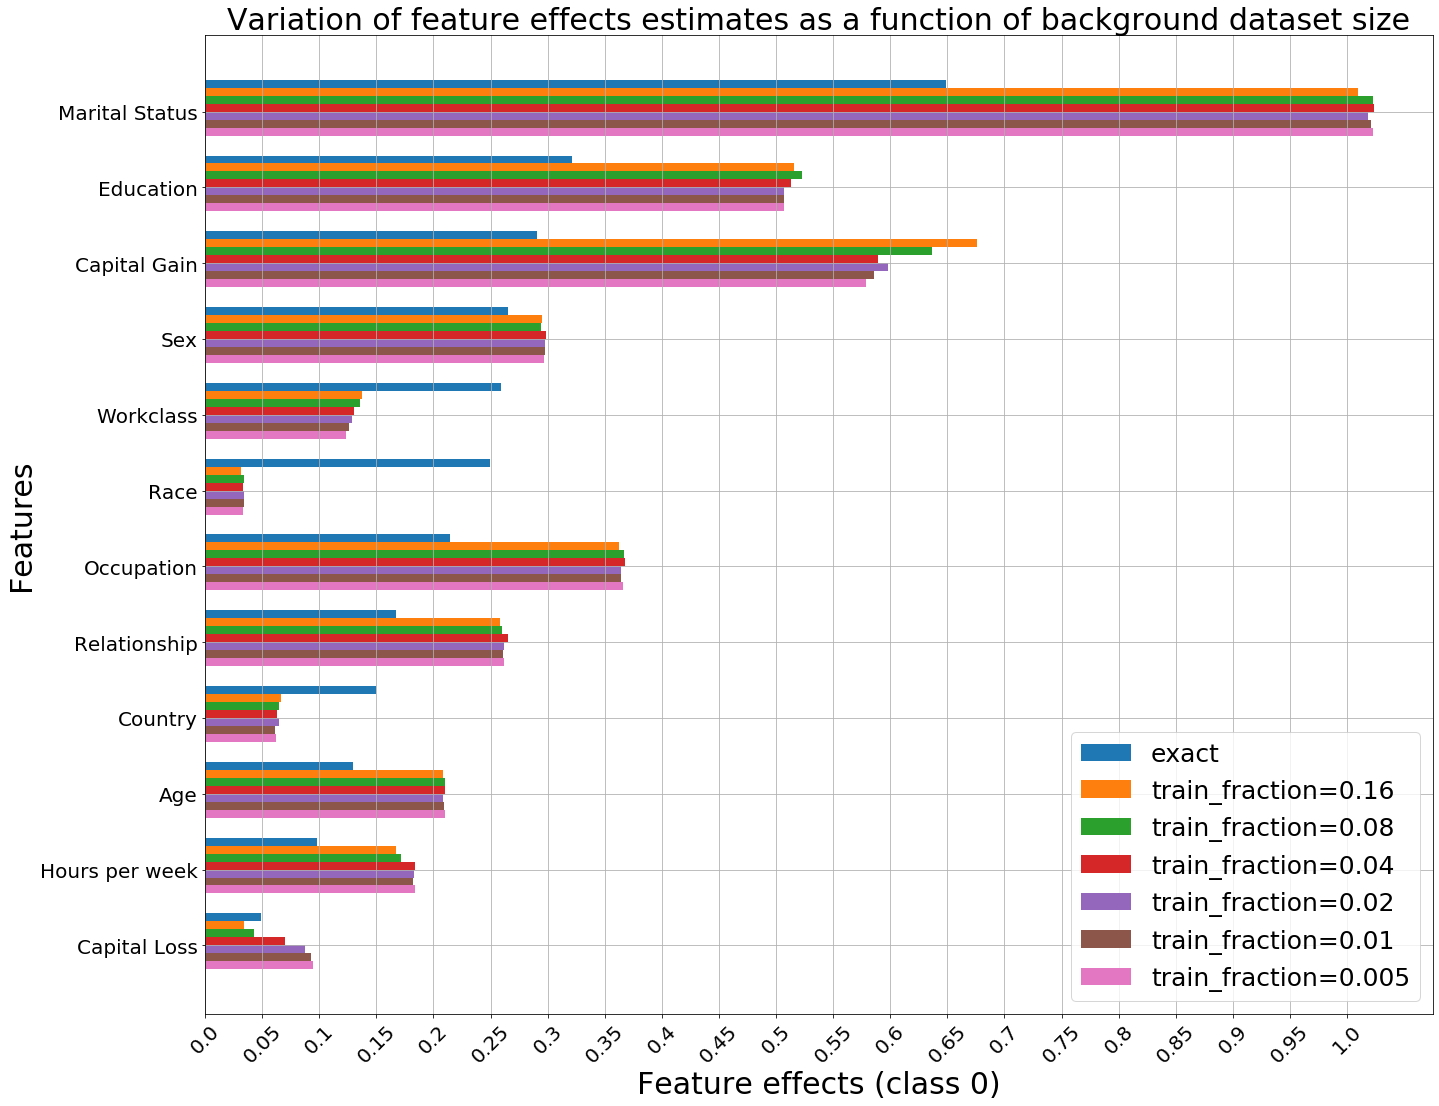

In [369]:
comparisons = exp_data['ranked_shap_vals']
methods = ['train_fraction={}'.format(fr) for fr in split_fractions] + ['exact']
_, fg, df = compare_avg_mag_shap(class_idx,
                                 comparisons,
                                 ranked_combined_exact_shap,
                                 methods=methods,
                                 fig_x=22,
                                 fig_y=18,
                                 bar_width=1,
                                 bar_space=9.5,
                                 xlabel="Feature effects (class {})".format(0),
                                 ylabel="Features",
                                 axes_label_fontsize=30,
                                 title="Variation of feature effects estimates as a function of background dataset size",
                                 title_fontsize=30,
                                 legend_fontsize=25,
                                )

We notice that with the exception of the `Capital Gain` and `Capital Loss`, the differences betweem the shap values estimates are not significant as the fraction of the training set used as a background dataset increases from `0.005` to `0.16`. Notably, the `Capital Gain` feature would be ranked as the second most important by the all approximate models, whereas in the initial experiment which used the first `100` (`0.003`) examples from the training set the ranking of the two features was reversed. How to select an appropriate background dataset is an open ended question. In the future, we will explore whether clustering the training data can provide a more representative background model and increase the accuracy of the estimation.

In [361]:
from IPython.display import Image
fg.savefig('background_effect.png', format='png')
Image(url="background_effect.png", width=1500, height=1500)

A potential limitation of expensive explanation methods such as KernelShap when used to draw insights about the global model behaviour is the fact that explaining large datasets can take a long time. Below, we explain a larger fraction of the testing set (`0.4`) in order to see if different conclusions about the feature importances would be made.

In [366]:
fraction_explained = 0.4 
X_explain_large, y_explain_large = split_set(X_test, 
                                 y_test, 
                                 fraction_explained, 
                                 )
X_explain_large_proc = preprocessor.transform(X_explain_large)
X_explain_large_proc_d = sparse2ndarray(X_explain_large_proc)

Number of records: 1024
Number of class 0: 763
Number of class 1: 261


In [ ]:
data = get_dataset(X_train, y_train, 0.08)
explainer = KernelShap(pred_fcn, link='logit')
explainer.fit(data, group_names=group_names, groups=groups)
explanation_large_dataset = explainer.explain(X_explain_large_proc_d)
ranked_avg_shap_l = get_ranked_values(explanation_large_dataset)

In [370]:
class_idx = 0 # income below $50,000
exact_shap_large = [(beta[:, None, :]*X_explain_large_proc_d)[i, ...] for i in range(beta.shape[0])] 
combined_exact_shap_large = [sum_categories(shap_values, cat_feat_start, feat_enc_dim) for shap_values in exact_shap_large]
ranked_combined_exact_shap_large = [rank_features(shap_values, perm_feat_names) for shap_values in combined_exact_shap_large]

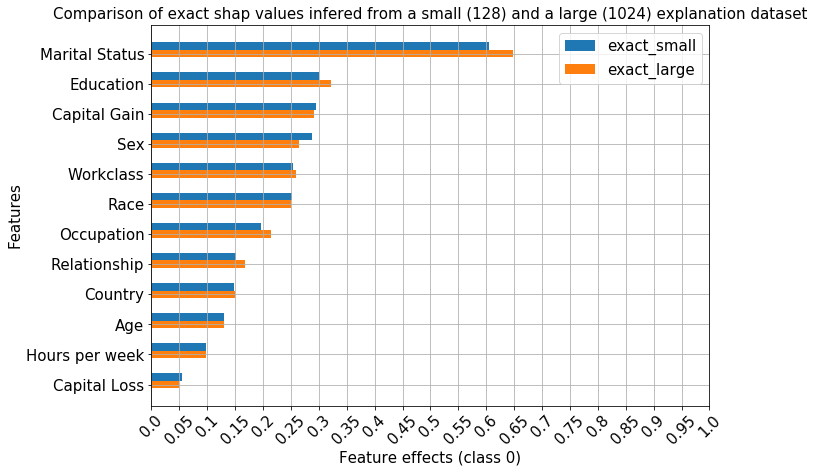

In [383]:
comparisons = [ranked_combined_exact_shap]
methods = ['exact_large', 'exact_small']
_, fg, df = compare_avg_mag_shap(class_idx,
                                 comparisons,
                                 ranked_combined_exact_shap_large,
                                 methods=methods,
                                 bar_width=0.5,
                                 legend_fontsize=15,
                                 axes_label_fontsize=15,
                                 tick_labels_fontsize=15,
                                 title="Comparison of exact shap values infered from a small (128) and a large (1024) explanation dataset",
                                 title_fontsize=15,
                                 xlabel='Feature effects (class {})'.format(class_idx),
                                 ylabel='Features'
                                )

As expected, the exact shap values have the same ranking when a larger set is explained, since they are derived from the same model coefficients. 

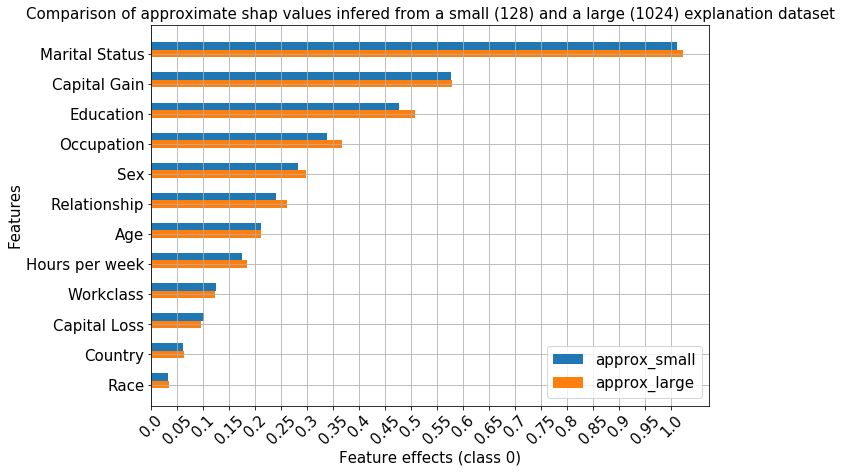

In [387]:
comparisons = [ranked_avg_shap]
methods = ['approx_large', 'approx_small']
_, fg, df = compare_avg_mag_shap(class_idx,
                                 comparisons,
                                 ranked_avg_shap_l,
                                 methods=methods,
                                 bar_width=0.5,
                                 legend_fontsize=15,
                                 axes_label_fontsize=15,
                                 tick_labels_fontsize=15,
                                 title="Comparison of approximate shap values infered from a small (128) and a large (1024) explanation dataset",
                                 title_fontsize=15,
                                 xlabel='Feature effects (class {})'.format(class_idx),
                                 ylabel='Features'
                                )

The ranking of the features also remains unchanged for the approximate method even when significantly more instances are explained.

In [389]:
with open('large_explain_set.pkl', 'wb') as f:
    pickle.dump(
        {'data': data,
         'explainer': explainer,
         'raw_shap': explanation_large_dataset,
         'ranked_shap_vals': ranked_avg_shap_l
        },
        f
    )

### Footnotes

<a id='footnotes'></a>
[**1**](#f_1): As detailed in *Theorem 1* in [[3]](#References), the estimation process for a shap value of feature $i$ from instance $x$ involves taking a weighted average of the contribution of feature $i$ to the model output, where the weighting takes into account all the possible orderings in which the previous and successor features can be added to the set. This computation is thus performed by choosing subsets of features from the full feature set and setting the values of these features to a *background value*; the prediction on these perturbed samples is used in  a least squares objective (*Theorem 2*), weighted by the Shapley kernel. Note that the optimisation objective involves a summation over all possible subsets. Enumerating all the feature subsets has exponential computational cost, so the smaller the feature set, the more samples can be drawn and more accurate shap values can be estimated. Thus, grouping the features can serve to reduce the variance of the shap values estimation by providing a smaller set of features to choose from.

[**2**](#f_2): This is a kwarg to `shap_values` method.

[**3**](#f_3): Note the progress bars below show, however, different runtimes between the two methods. No accurate timing analysis was carried out to study this aspect.

[**4**](#f_4): Note that the `shap` library currently does not support grouping when the data is represented as a sparse matrix, so it should be converted to a `numpy.ndarray` object, both during explainer initialisation and when calling the `shap_values` method. 

[**5**](#f_5): When `link='logit'` is passed to the plotting function, the model outputs are scaled to the probability space, so the _inverse logit transformation_ is applied to the data and axis ticks. This is in contrast to passing `link='logit'` to the KernelExplainer, which maps the model output through the *forward logit transformation*,
$\log \left( \frac{p}{1-p} \right)$.

[**6**](#f_6): We could alter the base value by specifying the `new_base_value` argument to  `shap.decision_plot`. Note that this argument has to be specified in the *same* units as the explanation - if we explained the instances in margin space then to switch the base value of the plot to, say, `p=0.4` then we would pass `new_base_value = log(0.4/(1 - 0.4))` to the plotting function.

[**7**](#f_7): In this context, bias refers to the bias-variance tradeoff; a simpler model will likely incur a larger error during training but will have a smaller generalisation gap compared to a more complex model which will have smaller training error but will generalise poorly. 

### References

<a id='ref_1'></a>
[[1]](#src_1) *Mahto, K.K., 2019. "One-Hot-Encoding, Multicollinearity and the Dummy Variable Trap". Retrieved 02 Feb 2020 [here](https://towardsdatascience.com/one-hot-encoding-multicollinearity-and-the-dummy-variable-trap-b5840be3c41a)*

[[2]](#src_2) *Mood, C., 2017. "Logistic regression: Uncovering unobserved heterogeneity."*

[[3]](#src_3) *Lundberg, S.M. and Lee, S.I., 2017. A unified approach to interpreting model predictions. In Advances in neural information processing systems (pp. 4765-4774).*

[[4]](#src_4) *Lundberg, S.M., Erion, G., Chen, H., DeGrave, A., Prutkin, J.M., Nair, B., Katz, R., Himmelfarb, J., Bansal, N. and Lee, S.I., 2020. From local explanations to global understanding with explainable AI for trees. Nature machine intelligence, 2(1), pp.56-67.*

[[5]](#https://www.nature.com/articles/s41551-018-0304-0) *Lundberg, S.M., Nair, B., Vavilala, M.S., Horibe, M., Eisses, M.J., Adams, T., Liston, D.E., Low, D.K.W., Newman, S.F., Kim, J. and Lee, S.I., 2018. Explainable machine-learning predictions for the prevention of hypoxaemia during surgery. Nature biomedical engineering, 2(10), pp.749-760.*